# 规则预测

In [5]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
# juppyrt ignore warning
import warnings
warnings.filterwarnings('ignore')

In [6]:
# 加载数据
raw_data = pd.read_csv('../fund_flow_simulated.csv')
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data = raw_data[['date', 'in', 'out', 'clus']]

In [7]:
raw_data

,date,in,out,clus
0,2023-01-01,0.000000e+00,0.000000e+00,clus
1,2023-01-02,6.561810e+09,7.426071e+09,clus
2,2023-01-03,5.197317e+09,4.312037e+09,clus
3,2023-01-04,4.116167e+09,5.732352e+09,clus
4,2023-01-05,5.416145e+09,4.041169e+09,clus
...,...,...,...,...
726,2024-12-27,4.213754e+09,5.134624e+09,clus
727,2024-12-28,0.000000e+00,0.000000e+00,clus
728,2024-12-29,0.000000e+00,0.000000e+00,clus
729,2024-12-30,5.925854e+09,4.967091e+09,clus


您的时间序列加权回归模型（TSWR）包含了多个不同的回归思想，以便应对商家的客流量预测问题。这个模型的核心在于将不同时间特征和商家特征加权，优化预测结果。以下是您提到的三个回归模型的详细描述，简要总结了它们的关键要点：

### 1. 最优常值回归（3.1.1）
- **基本思路**：预测商家在测试期间的14天的客流量，首先使用训练期间14天客流量的均值作为初步预测值。
- **优化目标**：通过寻找一个回归值，使得损失函数在训练期间28天内最小化，从而优化常值回归模型。
- **损失函数**：`YA = argmin_y (∑m∈M L(y, KA,m))`，选择使损失最小的回归值 `YA`。

### 2. 时间加权回归（3.1.2）
- **基本思路**：由于商家的经营情况随时间变化较大，距离测试时间段越近的样本更有价值，因此需要对每一天的样本加权。
- **权重函数设计**：
  - `w_m,A,1 = m - min(M_A)`：简单的时间距离权重。
  - `w_m,A,2 = (m - min(M))^3 × (m - min(M_A))`：考虑了时间距离和商家开始营业时间的非线性权重。
  - `w_m,A,3 = 1 / (m0 - m)`：考虑了离测试时间段首日的距离。
- **最终权重函数**：通过加权组合上述三个权重函数：`w_m,A = αw_m,A,1 + βw_m,A,2 + γw_m,A,3`，其中 `α + β + γ = 1`。
- **优化目标**：优化的目标是最小化带有加权损失函数的回归模型：`YA = argmin_y (∑m∈M L(y, KA,m) × w_m,A)`。

### 3. 曜日周期回归（3.1.3）
- **基本思路**：商家的客流量具有明显的周期性，尤其是在工作日和周末之间的差异，以及不同商家的周期性特征不同。
- **周期性建模**：
  - 通过曜日权重函数 `v(ψ1, ψ2)`，将训练时间段的曜日与测试时间段的曜日进行匹配。
  - `v` 的设计是为了在工作日或周末的情况下返回较大的权重，以捕捉周期性变化。
- **改进与样本利用**：通过选择近六个月的数据作为第二训练时间段，为每个曜日计算一个最优系数，最小化损失函数。
  - 优化目标：`pA,ψ = argmin_p (∑L(pY(3),A,m, KA,m))`，其中 `Y(3),A,m` 表示商家 A 在周期回归的预测值。
  - **最终回归**：利用周期性系数对测试时间段的预测进行修正：`YA,μ,2 = argmin_y (∑L(y, KA,m pA,ψ(μ)) × w_m,A × v(ψ(m), ψ(μ)))`。
  - **加权融合**：结合两种方法：`YA,μ = δYA,μ,1 + εYA,μ,2`，其中 `δ + ε = 1`，通过选择合适的加权系数 `δ` 和 `ε`，提高模型的精度。

### 总结：
这三个回归模型通过不同的方式调整了商家的客流量预测：
1. **最优常值回归**：以历史均值为基础，寻找最适合的回归值。
2. **时间加权回归**：考虑了时间的权重，特别是离测试时间段越近的样本越重要。
3. **周期回归**：通过周期性特征（如工作日与周末）和优化的周期系数来调整商家的客流量预测。

每个回归模型都在优化商家预测的准确性，同时充分考虑了时间、商家特性和周期性变化。根据线下测试，您可以选择不同的加权系数（如 `α`, `β`, `γ` 和 `δ`, `ε`）来进一步优化模型的表现。

要将您提到的三种回归方法（最优常值回归、时间加权回归和周期回归）应用到基金申赎数据中，我们可以根据您的数据特点进行适当的修改：

### 1. 最优常值回归（Optimized Constant Regression）
最优常值回归基于历史数据的均值预测未来的申赎量。您可以根据 `in` 或 `out` 列的历史均值来进行预测，但要考虑基金的客群分类 `clus`，因为不同客群的申赎行为可能不同。

#### 修改建议：
- **按客群分类**：对不同 `clus`（客户分类）进行单独建模，计算每个客群的历史均值，并基于这些均值来预测未来的 `in` 或 `out`。
- **优化回归**：根据您提供的公式，找到最优的常值回归值，即在训练时间段上使损失最小的均值。这可以通过遍历预测范围中的值，选取最小化损失的回归值。

```python
# 示例代码（假设使用Pandas）
df['in_pred'] = df.groupby('clus')['in'].transform('mean')  # 对每个客群计算均值
df['out_pred'] = df.groupby('clus')['out'].transform('mean')
```

### 2. 时间加权回归（Time-Weighted Regression）
在基金申赎数据中，时间的加权可能会反映出不同时间段的样本重要性，特别是离预测时间段越近的数据权重越大。

#### 修改建议：
- **按日期加权**：可以根据日期距离当前预测时间点的距离来加权。最近的日期样本赋予更高的权重。
- **按客群加权**：不同客群对时间的敏感度可能不同，您可以设计不同的权重函数，考虑到每个基金客群的历史趋势和近期申赎量的变化。

```python
import numpy as np

# 示例代码：按日期计算时间加权
df['date_weight'] = np.exp(-(df['date'] - df['date'].max()).dt.days / 30)  # 时间距离加权（假设30天衰减）
df['in_weighted'] = df['in'] * df['date_weight']
df['out_weighted'] = df['out'] * df['date_weight']
```

- **选择合适的权重函数**：如您在模型中提到的权重函数 `w_m,A`，您可以根据经验或通过交叉验证，选择合适的权重组合（例如，`α`, `β`, `γ`）来平衡不同时间的样本贡献。

### 3. 周期回归（Weekly Pattern Regression）
周期性回归考虑了不同时间段（如工作日与周末）或季节性因素对申赎行为的影响。您可以根据 `date` 列提取出星期几的信息，并针对每个星期进行周期性建模。

#### 修改建议：
- **按星期建模**：提取日期的“星期几”信息，可以根据每个星期的申赎行为优化周期回归。
- **季节性调整**：考虑季度或年度的季节性因素（例如，年底可能会有不同的申赎行为）。
  
```python
# 示例代码：提取星期几信息
df['weekday'] = df['date'].dt.weekday  # 0: Monday, 6: Sunday
df['is_weekend'] = df['weekday'].isin([5, 6])  # 标记周末

# 对每个星期几的申赎行为进行建模
df['in_weekday_pred'] = df.groupby('weekday')['in'].transform('mean')
df['out_weekday_pred'] = df.groupby('weekday')['out'].transform('mean')
```

- **周期系数优化**：可以通过交叉验证来选择最合适的周期系数，用于调整每个日期的申赎量预测。

### 总结修改建议：
1. **最优常值回归**：对每个 `clus` 计算历史均值，并选择损失最小的常值作为预测。
2. **时间加权回归**：为每个样本点计算基于时间的加权值，特别是最近的样本赋予更高的权重。
3. **周期回归**：通过提取日期的“星期几”信息，调整预测值，反映不同日期的周期性影响，或者根据季节性特征进行调整。

这些修改能使您的回归模型更好地适应基金申赎数据的特性，并提高预测的准确性。如果您需要进一步的代码示例或帮助，可以随时告诉我！

In [8]:
# 最优常值回归
import pandas as pd

# 假设 raw_data 已经是一个 pandas DataFrame

# 按 'clus' 对每个客群计算 'in' 和 'out' 的均值
raw_data['in_pred'] = raw_data.groupby('clus')['in'].transform('mean')
raw_data['out_pred'] = raw_data.groupby('clus')['out'].transform('mean')

# 输出结果查看
print(raw_data[['date', 'in', 'out', 'clus', 'in_pred', 'out_pred']].head())


        date            in           out  clus       in_pred      out_pred
0 2023-01-01  0.000000e+00  0.000000e+00  clus  3.512195e+09  3.506474e+09
1 2023-01-02  6.561810e+09  7.426071e+09  clus  3.512195e+09  3.506474e+09
2 2023-01-03  5.197317e+09  4.312037e+09  clus  3.512195e+09  3.506474e+09
3 2023-01-04  4.116167e+09  5.732352e+09  clus  3.512195e+09  3.506474e+09
4 2023-01-05  5.416145e+09  4.041169e+09  clus  3.512195e+09  3.506474e+09


In [9]:
# 时间加权回归（Time-Weighted Regression）

import numpy as np

# 转换 date 列为 datetime 格式（如果尚未转换）
raw_data['date'] = pd.to_datetime(raw_data['date'])

# 计算每一行数据与最新日期的天数差
max_date = raw_data['date'].max()
raw_data['days_diff'] = (max_date - raw_data['date']).dt.days

# 使用指数衰减函数来为每个样本点加权
raw_data['date_weight'] = np.exp(-raw_data['days_diff'] / 30)  # 假设30天为衰减周期

# 计算加权后的 'in' 和 'out' 值
raw_data['in_weighted'] = raw_data['in'] * raw_data['date_weight']
raw_data['out_weighted'] = raw_data['out'] * raw_data['date_weight']

# 查看加权结果
print(raw_data[['date', 'in', 'out', 'clus', 'in_weighted', 'out_weighted']].head())


        date            in           out  clus  in_weighted  out_weighted
0 2023-01-01  0.000000e+00  0.000000e+00  clus     0.000000      0.000000
1 2023-01-02  6.561810e+09  7.426071e+09  clus     0.183513      0.207684
2 2023-01-03  5.197317e+09  4.312037e+09  clus     0.150280      0.124682
3 2023-01-04  4.116167e+09  5.732352e+09  clus     0.123052      0.171368
4 2023-01-05  5.416145e+09  4.041169e+09  clus     0.167403      0.124905


In [10]:
# 周期回归
# 提取日期的星期几（0: Monday, 6: Sunday）
raw_data['weekday'] = raw_data['date'].dt.weekday

# 对每个星期几计算历史 'in' 和 'out' 的均值
raw_data['in_weekday_pred'] = raw_data.groupby('weekday')['in'].transform('mean')
raw_data['out_weekday_pred'] = raw_data.groupby('weekday')['out'].transform('mean')

# 如果需要根据周末与工作日的行为差异进行调整，可以添加如下标记：
raw_data['is_weekend'] = raw_data['weekday'].isin([5, 6])  # 标记是否为周末

# 输出周期性回归的预测结果
print(raw_data[['date', 'in', 'out', 'clus', 'weekday', 'in_weekday_pred', 'out_weekday_pred']].head())


        date            in           out  clus  weekday  in_weekday_pred  \
0 2023-01-01  0.000000e+00  0.000000e+00  clus        6     0.000000e+00   
1 2023-01-02  6.561810e+09  7.426071e+09  clus        0     4.928115e+09   
2 2023-01-03  5.197317e+09  4.312037e+09  clus        1     4.911550e+09   
3 2023-01-04  4.116167e+09  5.732352e+09  clus        2     4.880458e+09   
4 2023-01-05  5.416145e+09  4.041169e+09  clus        3     4.985056e+09   

   out_weekday_pred  
0      0.000000e+00  
1      4.871534e+09  
2      4.926906e+09  
3      4.911552e+09  
4      4.910545e+09  


In [11]:
# 按日期加权的周期回归
raw_data['in_combined_pred'] = raw_data['in_weekday_pred'] * raw_data['date_weight']
raw_data['out_combined_pred'] = raw_data['out_weekday_pred'] * raw_data['date_weight']

# 输出最终的预测结果
print(raw_data[['date', 'in', 'out', 'clus', 'in_combined_pred', 'out_combined_pred']].head())


        date            in           out  clus  in_combined_pred  \
0 2023-01-01  0.000000e+00  0.000000e+00  clus          0.000000   
1 2023-01-02  6.561810e+09  7.426071e+09  clus          0.137824   
2 2023-01-03  5.197317e+09  4.312037e+09  clus          0.142017   
3 2023-01-04  4.116167e+09  5.732352e+09  clus          0.145901   
4 2023-01-05  5.416145e+09  4.041169e+09  clus          0.154079   

   out_combined_pred  
0           0.000000  
1           0.136242  
2           0.142461  
3           0.146830  
4           0.151776  


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假设 raw_data 是您的 DataFrame
raw_data['date'] = pd.to_datetime(raw_data['date'])

# 定义预测周期，假设我们预测未来14天
forecast_days = 14

# 提取最优常值回归、时间加权回归、周期回归的预测结果
def optimize_constant_regression(df, current_date, target_col, forecast_days=14):
    """基于历史均值预测未来14天"""
    df_current = df[df['date'] <= current_date]  # 获取当前日期之前的数据
    constant_pred_value = df_current.groupby('clus')[target_col].mean().reset_index()
    
    # 对于最优常值回归，未来14天预测值相同，基于历史均值
    forecast_dates = [current_date + pd.Timedelta(days=i) for i in range(1, forecast_days + 1)]
    constant_pred_value = constant_pred_value.loc[constant_pred_value.index.repeat(forecast_days)].reset_index(drop=True)
    constant_pred_value['forecast_date'] = forecast_dates * len(constant_pred_value['clus'].unique())
    constant_pred_value['constant_pred'] = constant_pred_value[target_col]
    return constant_pred_value[['clus', 'forecast_date', 'constant_pred']]

def time_weighted_regression(df, current_date, target_col, forecast_days=14):
    """时间加权回归，根据距离测试日期的天数计算加权预测"""
    time_weighted_preds = []
    max_date = df['date'].max()
    
    for i in range(1, forecast_days + 1):
        forecast_date = current_date + pd.Timedelta(days=i)
        df['days_diff'] = (max_date - df['date']).dt.days
        df['date_weight'] = np.exp(-df['days_diff'] / 30)  # 假设30天的衰减
        
        # 计算每个时间点的加权预测
        weighted_pred = df.groupby('clus').apply(lambda x: np.sum(x[target_col] * x['date_weight']) / np.sum(x['date_weight'])).reset_index()
        weighted_pred.columns = ['clus', 'weighted_pred']
        weighted_pred['forecast_date'] = forecast_date
        time_weighted_preds.append(weighted_pred)
    
    # 合并所有预测结果
    time_weighted_preds_df = pd.concat(time_weighted_preds, ignore_index=True)
    return time_weighted_preds_df

def weekly_pattern_regression(df, current_date, target_col, forecast_days=14):
    """周期回归，基于星期几的周期性预测"""
    weekly_preds = []
    current_weekday = current_date.weekday()  # 获取当前日期的星期几
    
    for i in range(1, forecast_days + 1):
        forecast_date = current_date + pd.Timedelta(days=i)
        forecast_weekday = forecast_date.weekday()
        
        df['weekday'] = df['date'].dt.weekday
        weekday_pred = df[df['weekday'] == forecast_weekday].groupby('clus')[target_col].mean().reset_index()
        weekday_pred.columns = ['clus', 'weekday_pred']
        weekday_pred['forecast_date'] = forecast_date
        weekly_preds.append(weekday_pred)
    
    # 合并所有预测结果
    weekly_preds_df = pd.concat(weekly_preds, ignore_index=True)
    return weekly_preds_df

def generate_single_forecast(raw_data, current_date, forecast_days=14, pred_column='in'):
    """为每个日期生成未来14天的预测"""
    # 获取常值回归预测
    constant_pred = optimize_constant_regression(raw_data, current_date, pred_column, forecast_days)
    
    # 获取时间加权回归预测
    time_weighted_pred = time_weighted_regression(raw_data, current_date, pred_column, forecast_days)
    
    # 获取周期回归预测
    weekly_pred = weekly_pattern_regression(raw_data, current_date, pred_column, forecast_days)
    
    # 合并所有预测
    forecast_result = constant_pred.merge(time_weighted_pred, on=['clus', 'forecast_date'], how='left')
    forecast_result = forecast_result.merge(weekly_pred, on=['clus', 'forecast_date'], how='left')
    
    # 计算最终预测值（可以根据需要调整加权方式）
    forecast_result['final_pred'] = forecast_result[['weighted_pred', 'weekday_pred']].mean(axis=1)  # 使用加权平均
    forecast_result = forecast_result[['clus', 'forecast_date', 'final_pred', 'constant_pred', 'weighted_pred', 'weekday_pred']]
    
    return forecast_result

# 假设 raw_data 已经按日期排序，并且包含目标列 'in' 和 'out'
pred_column = 'in'  # 预测的列名，'in' 或 'out'
current_date = pd.to_datetime('2023-02-01')  # 示例当前日期
forecast_result = generate_single_forecast(raw_data, current_date, forecast_days, pred_column=pred_column)



ModuleNotFoundError: No module named 'matplotlib'

In [45]:
forecast_result

,clus,forecast_date,final_pred,constant_pred,weighted_pred,weekday_pred
0,clus,2023-02-02,4.220034e+09,3.798265e+09,3.455013e+09,4.985056e+09
1,clus,2023-02-03,4.170949e+09,3.798265e+09,3.455013e+09,4.886885e+09
2,clus,2023-02-04,1.727506e+09,3.798265e+09,3.455013e+09,0.000000e+00
3,clus,2023-02-05,1.727506e+09,3.798265e+09,3.455013e+09,0.000000e+00
4,clus,2023-02-06,4.191564e+09,3.798265e+09,3.455013e+09,4.928115e+09
5,clus,2023-02-07,4.183281e+09,3.798265e+09,3.455013e+09,4.911550e+09
6,clus,2023-02-08,4.167736e+09,3.798265e+09,3.455013e+09,4.880458e+09
7,clus,2023-02-09,4.220034e+09,3.798265e+09,3.455013e+09,4.985056e+09
8,clus,2023-02-10,4.170949e+09,3.798265e+09,3.455013e+09,4.886885e+09
9,clus,2023-02-11,1.727506e+09,3.798265e+09,3.455013e+09,0.000000e+00


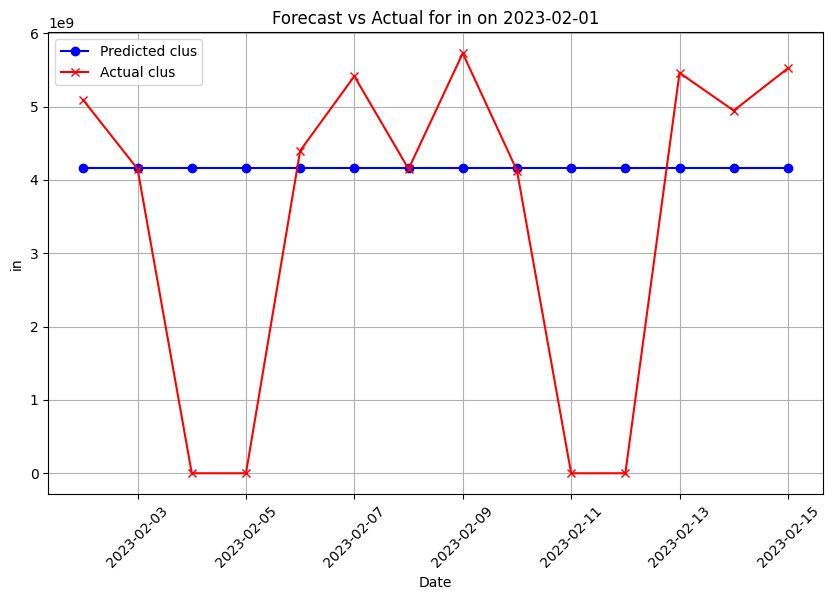

In [26]:
# 可视化预测与真实值对比
def plot_forecast_comparison(raw_data, forecast_result, current_date, target_col='in'):
    # 获取未来14天的预测日期
    forecast_dates = forecast_result['forecast_date'].unique()

    # 获取对应时间段的真实值（假设未来14天的数据存在）
    true_values = raw_data[(raw_data['date'].isin(forecast_dates)) & (raw_data['clus'].isin(forecast_result['clus']))]

    # 对比预测与真实值
    plt.figure(figsize=(10, 6))
    for clus in forecast_result['clus'].unique():
        # 获取每个 `clus` 的预测值
        forecast_clu = forecast_result[forecast_result['clus'] == clus]
        true_clu = true_values[true_values['clus'] == clus]

        plt.plot(forecast_clu['forecast_date'], forecast_clu['daily_pred'], label=f'Predicted {clus}', marker='o', color='blue')
        plt.plot(true_clu['date'], true_clu[target_col], label=f'Actual {clus}', marker='x', color='red')
    
    plt.title(f"Forecast vs Actual for {target_col} on {current_date.strftime('%Y-%m-%d')}")
    plt.xlabel('Date')
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# 可视化回测对比（以 'in' 列为例）
plot_forecast_comparison(raw_data, forecast_result, current_date, target_col='in')

In [ ]:
# 读取用户支付数据，并计算日期相关的衍生字段
yhzf = pd.read_csv("user_pay.txt", names=["yh_id", "sj_id", "sj"], parse_dates=["sj"])  # 读取支付记录，包含用户ID、商家ID和时间
yhzf["rx"] = (yhzf["sj"] - pd.Timestamp("2016-11-01")).dt.days  # 计算每条记录相对于2016-11-01的天数差
yhzf["yr"] = (yhzf["rx"] + 904) % 7 + 1  # 计算周几（1-7表示周一到周日），偏移调整确保一致性

# 读取商家特征信息
sjtz = pd.read_csv(
    "shop_info.txt",
    names=["sj_id", "sm", "wzbh", "rjxf", "pf", "pls", "mddj", "yjplmc", "ejflmc", "sjflmc"],
    encoding="utf-8"
)  # 商家信息，包含商家ID、位置编号、评分等特征

# 读取天气数据，并计算日期相关的衍生字段
tq = pd.read_csv("weather.txt", names=["sm", "rq", "tq"], parse_dates=["rq"])  # 天气数据，包含位置、日期和天气指数
tq["rx"] = (tq["rq"] - pd.Timestamp("2016-11-01")).dt.days  # 计算相对于2016-11-01的天数差

# 聚合流量数据
xl = yhzf.groupby(["sj_id", "rx", "yr"]).size().reset_index(name="sjkll")  # 按商家ID、天数和周几统计流量

# 定义核心计算函数
def calculate_predictions(xl, sjtz, tq, qsrx, fw, fwa=None, r=0, s=0):
    """
    根据输入数据和参数计算预测值。
    - xl: 聚合的流量数据
    - sjtz: 商家特征数据
    - tq: 天气数据
    - qsrx: 起始天数
    - fw: 预测窗口范围
    - fwa: 加权窗口
    - r, s: 其他控制参数，表示是否执行特定调整逻辑
    """
    # 具体计算逻辑需要基于业务需求实现，与R代码的逻辑等价
    pass

# 定义分布式预测函数
def qdyc(a, xl, sjtz, tq):
    """
    对单个类别进行预测。
    - a: 类别编号
    - xl, sjtz, tq: 数据集
    """
    fw_map = {
        1: [-1, -21, -36, -42],  # 类别1的时间窗口
        2: [-1, -21, -29, -42],  # 类别2的时间窗口
        3: [-1, -21],  # 类别3的时间窗口
        4: [-1, -28],  # 类别4的时间窗口
        5: [-1, -7],  # 类别5的时间窗口
        6: [-1, -14],  # 类别6的时间窗口
        7: [-1, -21],  # 类别7的时间窗口
        8: [-1, -21, -36, -42]  # 类别8的时间窗口
    }
    weights = [0.30, 0.10, 0.10, 0.10, 0.07, 0.09, 0.11, 0.13]  # 每个类别的权重
    fw = fw_map[a]  # 获取类别对应的时间窗口
    weight = weights[a - 1]  # 获取类别对应的权重
    return weight * calculate_predictions(
        xl, sjtz, tq, 0, fw, fwa=fw, r=1 if a in [1, 2, 3, 4] else 0, s=1 if a in [5, 6, 7, 8] else 0
    )  # 按条件设置参数并调用计算函数

# 并行计算预测
with Pool(4) as pool:  # 使用多进程加速计算
    results = pool.starmap(qdyc, [(a, xl, sjtz, tq) for a in range(1, 9)])  # 对每个类别进行预测并收集结果

# 合并预测结果
yca = pd.DataFrame({"sj_id": np.repeat(sjtz["sj_id"].values, 14), "rx": np.tile(np.arange(14), len(sjtz))})  # 构建预测结果模板
yca["yc"] = sum(results)  # 汇总所有类别的预测结果

# 后处理与输出
yca = yca.merge(sjtz[["sj_id", "sm"]], on="sj_id", how="left")  # 合并商家信息
yca = yca.merge(tq[["rx", "sm", "tq"]], on=["rx", "sm"], how="left")  # 合并天气信息
yca["tq"].fillna(0, inplace=True)  # 填充天气数据中的空值
yca["yc"] = yca["yc"] * (1 + 0.005 * yca["tq"])  # 根据天气指数调整预测值
yca.loc[yca["rx"] == 10, "yc"] *= 1.1  # 对特定天数的预测值进行额外调整
yca["yc"] = yca["yc"].astype(int)  # 将预测值转换为整数
yca.sort_values(["sj_id", "rx"], inplace=True)  # 按商家ID和日期排序

# 导出结果
result = yca.pivot(index="sj_id", columns="rx", values="yc").reset_index()  # 将数据透视为以商家为索引的表格
result.columns = ["sj_id"] + [f"r{i}" for i in range(14)]  # 重命名列
result.to_csv("0.csv", index=False, header=False)  # 导出预测结果


In [ ]:
# 读取用户支付数据，并计算日期相关的衍生字段
yhzf = pd.read_csv("user_pay.txt", names=["yh_id", "sj_id", "sj"], parse_dates=["sj"])  # 读取支付记录，包含用户ID、商家ID和时间
yhzf["rx"] = (yhzf["sj"] - pd.Timestamp("2016-11-01")).dt.days  # 计算每条记录相对于2016-11-01的天数差
yhzf["yr"] = (yhzf["rx"] + 904) % 7 + 1  # 计算周几（1-7表示周一到周日），偏移调整确保一致性

# 读取商家特征信息
sjtz = pd.read_csv(
    "shop_info.txt",
    names=["sj_id", "sm", "wzbh", "rjxf", "pf", "pls", "mddj", "yjplmc", "ejflmc", "sjflmc"],
    encoding="utf-8"
)  # 商家信息，包含商家ID、位置编号、评分等特征

# 读取天气数据，并计算日期相关的衍生字段
tq = pd.read_csv("weather.txt", names=["sm", "rq", "tq"], parse_dates=["rq"])  # 天气数据，包含位置、日期和天气指数
tq["rx"] = (tq["rq"] - pd.Timestamp("2016-11-01")).dt.days  # 计算相对于2016-11-01的天数差

# 聚合流量数据
xl = yhzf.groupby(["sj_id", "rx", "yr"]).size().reset_index(name="sjkll")  # 按商家ID、天数和周几统计流量

# 定义核心计算函数
def calculate_predictions(xl, sjtz, tq, qsrx, fw, fwa=None, r=0, s=0):
    """
    根据输入数据和参数计算预测值。
    - xl: 聚合的流量数据
    - sjtz: 商家特征数据
    - tq: 天气数据
    - qsrx: 起始天数
    - fw: 预测窗口范围
    - fwa: 加权窗口
    - r, s: 其他控制参数，表示是否执行特定调整逻辑
    """
    # 具体计算逻辑需要基于业务需求实现，与R代码的逻辑等价
    pass

# 定义分布式预测函数
def qdyc(a, xl, sjtz, tq):
    """
    对单个类别进行预测。
    - a: 类别编号
    - xl, sjtz, tq: 数据集
    """
    fw_map = {
        1: [-1, -21, -36, -42],  # 类别1的时间窗口
        2: [-1, -21, -29, -42],  # 类别2的时间窗口
        3: [-1, -21],  # 类别3的时间窗口
        4: [-1, -28],  # 类别4的时间窗口
        5: [-1, -7],  # 类别5的时间窗口
        6: [-1, -14],  # 类别6的时间窗口
        7: [-1, -21],  # 类别7的时间窗口
        8: [-1, -21, -36, -42]  # 类别8的时间窗口
    }
    weights = [0.30, 0.10, 0.10, 0.10, 0.07, 0.09, 0.11, 0.13]  # 每个类别的权重
    fw = fw_map[a]  # 获取类别对应的时间窗口
    weight = weights[a - 1]  # 获取类别对应的权重
    return weight * calculate_predictions(
        xl, sjtz, tq, 0, fw, fwa=fw, r=1 if a in [1, 2, 3, 4] else 0, s=1 if a in [5, 6, 7, 8] else 0
    )  # 按条件设置参数并调用计算函数

# 并行计算预测
with Pool(4) as pool:  # 使用多进程加速计算
    results = pool.starmap(qdyc, [(a, xl, sjtz, tq) for a in range(1, 9)])  # 对每个类别进行预测并收集结果

# 合并预测结果
yca = pd.DataFrame({"sj_id": np.repeat(sjtz["sj_id"].values, 14), "rx": np.tile(np.arange(14), len(sjtz))})  # 构建预测结果模板
yca["yc"] = sum(results)  # 汇总所有类别的预测结果

# 后处理与输出
yca = yca.merge(sjtz[["sj_id", "sm"]], on="sj_id", how="left")  # 合并商家信息
yca = yca.merge(tq[["rx", "sm", "tq"]], on=["rx", "sm"], how="left")  # 合并天气信息
yca["tq"].fillna(0, inplace=True)  # 填充天气数据中的空值
yca["yc"] = yca["yc"] * (1 + 0.005 * yca["tq"])  # 根据天气指数调整预测值
yca.loc[yca["rx"] == 10, "yc"] *= 1.1  # 对特定天数的预测值进行额外调整
yca["yc"] = yca["yc"].astype(int)  # 将预测值转换为整数
yca.sort_values(["sj_id", "rx"], inplace=True)  # 按商家ID和日期排序

# 导出结果
result = yca.pivot(index="sj_id", columns="rx", values="yc").reset_index()  # 将数据透视为以商家为索引的表格
result.columns = ["sj_id"] + [f"r{i}" for i in range(14)]  # 重命名列
result.to_csv("0.csv", index=False, header=False)  # 导出预测结果
